In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from sklearn import svm, metrics
from sklearn.feature_selection import mutual_info_classif
import random
import statistics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import LeaveOneGroupOut #https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.LeaveOneGroupOut.html

from sklearn.metrics import mutual_info_score, normalized_mutual_info_score,adjusted_mutual_info_score
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE, SelectKBest
from sklearn.metrics import accuracy_score
import pprint

In [2]:
data_labels_df=pd.read_csv("labels.csv",header=None)
data_labels_df.columns=['labels']
data_features_df=pd.read_csv("data.csv", header=None)
data_columns_list=list(pd.read_csv("feature_names.csv"))

data_features_df.columns=data_columns_list #merging the columns file and data file

In [3]:
data_features_df.head(5)

,alpha_ec_0,alpha_ec_1,alpha_ec_2,alpha_ec_3,alpha_ec_4,alpha_ec_5,alpha_ec_6,alpha_ec_7,alpha_ec_8,alpha_ec_9,...,ratio_theta_38,ratio_theta_39,ratio_theta_40,ratio_theta_41,ratio_theta_42,ratio_theta_43,ratio_theta_44,ratio_theta_45,ratio_theta_46,ratio_theta_47
0,0.11184,0.12387,0.12858,0.11324,0.10571,0.10690,0.10756,0.11064,0.10875,0.15893,...,0.57161,0.73870,0.58709,0.55198,0.54811,0.57869,0.59345,0.60436,0.56294,1.01440
1,0.29834,0.26881,0.26239,0.38009,0.34358,0.28500,0.24791,0.25033,0.26047,0.26016,...,0.35142,0.32788,0.43164,0.49603,0.40680,0.31283,0.66352,0.58386,0.46658,0.74867
2,0.36912,0.39587,0.38999,0.25772,0.40554,0.44199,0.44004,0.39947,0.31546,0.28348,...,0.61924,0.86506,1.09310,0.31759,0.36353,0.50553,0.33478,0.49383,0.62363,0.61417
3,0.76120,0.77726,0.77042,0.60161,0.70183,0.72725,0.76245,0.78904,0.72984,0.52236,...,0.23456,0.25090,0.43196,0.71301,0.53340,0.28528,0.68135,0.66315,0.25250,0.85448
4,0.16770,0.15146,0.14714,0.15728,0.14965,0.14154,0.13228,0.12760,0.14351,0.17252,...,1.82160,1.73190,1.24420,2.76220,3.00930,2.43520,2.53070,2.58470,2.00770,2.29460


## Mutual Information method:

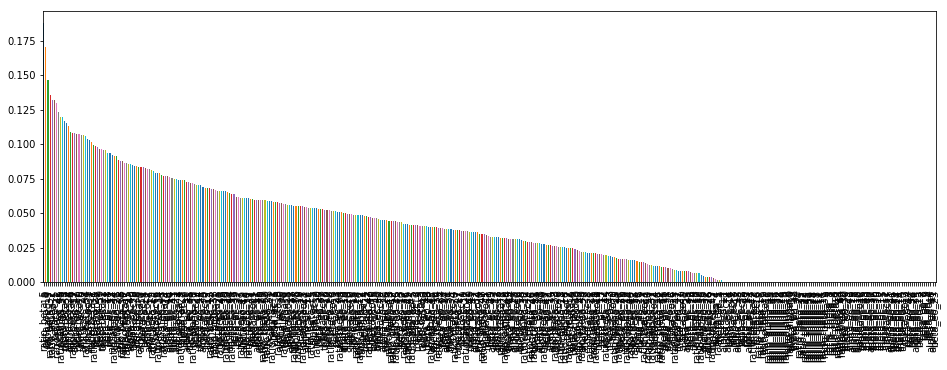

In [4]:
mi_data=mutual_info_classif(data_features_df,data_labels_df) #MI of the entire data
mi_series=pd.Series(mi_data,index=data_features_df.columns.tolist()) #creating a series 

mi_series.sort_values(ascending=False, inplace=True) #sorting the series in descending order to generate a meaningful bar graph

mi_series.plot.bar(figsize=(16,5))


### We can see that there are high mutual information between features and the target variable. However, there is an exponential decrease in the mutual information. And some features don't have any mutual information with the target variable.

In [5]:
#helper function to get generate a final validation dataset for final classifier comparison
#it uses the same the concept of LeaveOneGroupOut

def custom_train_test_split(x,y,split_group_size=3,random_state=123):
    
    '''
    Parameters:
    x =>Feature (dataframe)
    y =>Label (dataframe)
    split_group_size => The groups we want in our validation set
    random_state => random.seed()
    
    ----------------------------------------------------------------------------
    This function splits the data into test and train splits. This works like Leave One Group Out concept where it doesn't
    split random rows but splits random groups.
    
    This function ensures that the test set will have both the classes (1s and 0s).
    
    -----------------------------------------------------------------------------
    Returns dataframes and a variable
    
    
    '''
        
    random.seed(random_state)  
    choice_list=[x for x in range(18)]
    groups=[x for x in range(18)]*10 #for using in LeaveOneGroupOut #180 length
    groups.sort()
    groups=np.array(groups).reshape(180,1) #groups.sort is sorted list which then converted to numpy array
    groups_df=pd.DataFrame(groups,columns=['groups'])
    
    main_data_df=pd.concat([x,y], axis=1) #it contains features with last column as target variable
    main_data_df=pd.concat([main_data_df,groups_df],axis=1) #the last column is the groups column now
    
    test_df=pd.DataFrame()
    train_df=pd.DataFrame()
    
    #Objective is to always select both the classes in Test data:
    
    if split_group_size==2:
        #selecting positive class for the test data
        temp_df=main_data_df[main_data_df['labels']==1] #selecting a portion of the main_df where labels column are 1
        random_patient=random.choice(list(set(temp_df['groups'].values.tolist()))) #selecting the group randomly  from temp_df and randomly picking a group
        test_df=pd.concat([temp_df[temp_df['groups']==random_patient],test_df], axis=0) #this selects that random patient rows and store in test_df
        main_data_df.drop(main_data_df[main_data_df['groups']==random_patient].index, inplace=True)
        #this line will remove that patient rows from main_data_df. This patient is a POSITIVE class
        
        #selecting negative class for the test data 
        temp_df=main_data_df[main_data_df['labels']==0] #selecting a portion of the main_df where labels column are 0
        random_patient=random.choice(list(set(temp_df['groups'].values.tolist()))) #selecting the group randomly  from temp_df and randomly picking a group
        test_df=pd.concat([temp_df[temp_df['groups']==random_patient],test_df], axis=0) #this selects that random patient rows and store in test_df
        main_data_df.drop(main_data_df[main_data_df['groups']==random_patient].index, inplace=True)
        #this line will remove that patient rows from main_data_df. This patient is a NEGATIVE class
        
    else:
        #must select atleast one 1 class and one 0 class
        #selecting positive class for the test data
        temp_df=main_data_df[main_data_df['labels']==1] #selecting a portion of the main_df where labels column are 1
        random_patient=random.choice(list(set(temp_df['groups'].values.tolist()))) #selecting the group randomly  from temp_df and randomly picking a group
        test_df=pd.concat([temp_df[temp_df['groups']==random_patient],test_df], axis=0) #this selects that random patient rows and store in test_df
        main_data_df.drop(main_data_df[main_data_df['groups']==random_patient].index, inplace=True)
        #this line will remove that patient rows from main_data_df. This patient is a POSITIVE class
        
        #selecting negative class for the test data 
        temp_df=main_data_df[main_data_df['labels']==0] #selecting a portion of the main_df where labels column are 0
        random_patient=random.choice(list(set(temp_df['groups'].values.tolist()))) #selecting the group randomly  from temp_df and randomly picking a group
        test_df=pd.concat([temp_df[temp_df['groups']==random_patient],test_df], axis=0) #this selects that random patient rows and store in test_df
        main_data_df.drop(main_data_df[main_data_df['groups']==random_patient].index, inplace=True)
        #this line will remove that patient rows from main_data_df. This patient is a NEGATIVE class
        
        #Two groups selected for test data already above, remaining group(s) will be random selection:
           
    
        for i in range(split_group_size-2):
            random_pick=random.choice(list(set(main_data_df['groups'].values.tolist())))  #picking a random number from the groups column
            #choice_list.remove(random_pick) #removing it from the choice_list so that in the next iteration the same number doesn't get picked
            test_df=pd.concat((main_data_df[main_data_df['groups']==random_pick],test_df)) #concatenating X_test on top of X_test in each iteration to build the test set
            main_data_df.drop(main_data_df[main_data_df['groups']==random_pick].index, inplace=True) #Permanently dropping this patient group in each iteration from the main_data_df
            
    
     #now main_data_df won't have the test patient groups data in it, so it is our train set dataframe
        
        
        
    X_train_df=main_data_df.iloc[:,0:-2] #the last two columns are target label and a group column added in the previous lines 
    Y_train_df=main_data_df.iloc[:,-2] #the 2nd last column is target data
    X_test_df= test_df.iloc[:,0:-2]
    Y_test_df= test_df.iloc[:,-2]
    groups=    18-split_group_size
    #groups variable will be fed to LeaveOneGroupOut while training 
    
    X_train_df.reset_index(drop=True,inplace=True) #resets the index, drops the old index as it will get added as a column and order is important 
    Y_train_df.reset_index(drop=True,inplace=True)
    X_test_df.reset_index(drop=True, inplace=True)
    Y_test_df.reset_index(drop=True, inplace=True)
    
    
    return X_train_df,X_test_df,Y_train_df,Y_test_df,groups



#custom_train_test_split(x=data_features_df,y=data_labels_df,split_group_size=2,random_state=123)




### Mutual Information using LeaveOneOutGroup.

### First splitting train - test using a custom made function

In [6]:
'''this custom splitting ensures that the test set always has both the classes. This is important because otherwise accuracy
will be suffer
'''
X_train_val, X_test_val, Y_train_val,Y_test_val,groups=\
                       custom_train_test_split(x=data_features_df,y=data_labels_df,split_group_size=3,random_state=123)

group_cv=[x for x in range(groups)]*10
group_cv.sort()

logistic_clf=LogisticRegression()

logo_cv = LeaveOneGroupOut()

avg_accuracy_list_logistic=avg_score_list_logistic=[]

mi_selected_columns=dict()

mi_ranks=[x for x in range(10,433,10)]
for rank in mi_ranks:
    
    mi=SelectKBest(mutual_info_classif,k=rank)
    new_features_mi=mi.fit_transform(X_train_val, Y_train_val)
    
    mi_selected_columns[rank]=mi.get_support(indices=True) #keeps track of columns chosen SelectKBest in the dictionary
    
    accuracy_list=[] 
    score_list=[]
    
    for train, test in logo_cv.split(new_features_mi, Y_train_val.values, group_cv):
       
        X_train_cv, X_test_cv = new_features_mi[train], new_features_mi[test]
        Y_train_cv, Y_test_cv = Y_train_val.values[train], Y_train_val.values[test]     
        
        logistic_clf.fit(X_train_cv,Y_train_cv)
        
        y_predict=logistic_clf.predict(X_test_cv)
        
        tp=fp=tn=fn=i=0
        
        while i < len(y_predict):
            if Y_test_cv[i]==1 and y_predict[i]==1:             #corresponding actual y=1 and prediction =1 then it is True+ve
                tp=tp+1
            elif Y_test_cv[i]==0 and y_predict[i]==1:           #corresponding actual y=0 and prediction =1 then it is False+ve
                fp=fp+1
            elif Y_test_cv[i]==0 and y_predict[i]==0:           #corresponding actual y=0 and prediction =0 then it is True-ve
                tn=tn+1
            else:                                               #corresponding actual y=1 and prediction =0 then it is False-ve
                fn=fn+1
            i+=1
            
        accuracy=(tp+tn)/(tp+tn+fp+fn)                          #accuracy formula
        accuracy_list.append(accuracy)                          #storing history data in accuracy_list
        #accuracy_scores=accuracy_score(Y_test_cv.tolist(),y_predict.tolist())
        #score_list.append(accuracy_scores)
        
    avg_accuracy_list_logistic.append(statistics.mean(accuracy_list))
    #finally adding the average accuracy of each model
    
    #avg_score_list_logistic.append(statistics.mean(score_list))    

best_rank=mi_ranks[avg_accuracy_list_logistic.index(max(avg_accuracy_list_logistic))]

#best_rank_score=mi_ranks[avg_score_list_logistic.index(max(avg_score_list_logistic))]
print(f"The average accuracy collected at every iteration:{avg_accuracy_list_logistic}")
print("\n")
print(f"The best rank is {best_rank} at highest accuracy ({max(avg_accuracy_list_logistic):.3f}) from LOGO cross-validation ")
print("\n")


#print(f"The best rank is {best_rank_score} at highest accuracy ({max(avg_score_list_logistic):.3f}) from LOGO cross-validation ")


'''The accuracy formula accuracy=(tp+tn)/(tp+tn+fp+fn) or the accuracy_score(Y_test_cv.tolist(),y_predict.tolist())
give the same result, so using anyone of them'''

The average accuracy collected at every iteration:[0.6733333333333333, 0.7066666666666667, 0.74, 0.7666666666666667, 0.7266666666666667, 0.7466666666666667, 0.7466666666666667, 0.7666666666666667, 0.7666666666666667, 0.8, 0.8, 0.8066666666666666, 0.82, 0.8266666666666667, 0.8466666666666667, 0.8466666666666667, 0.8333333333333334, 0.8266666666666667, 0.7933333333333333, 0.8, 0.7933333333333333, 0.78, 0.78, 0.7733333333333333, 0.7866666666666666, 0.7866666666666666, 0.7666666666666667, 0.7533333333333333, 0.76, 0.7866666666666666, 0.7733333333333333, 0.7666666666666667, 0.7666666666666667, 0.76, 0.8066666666666666, 0.8066666666666666, 0.8, 0.8, 0.8, 0.8066666666666666, 0.8066666666666666, 0.8066666666666666, 0.8]


The best rank is 150 at highest accuracy (0.847) from LOGO cross-validation 




'The accuracy formula accuracy=(tp+tn)/(tp+tn+fp+fn) or the accuracy_score(Y_test_cv.tolist(),y_predict.tolist())\ngive the same result, so using anyone of them'

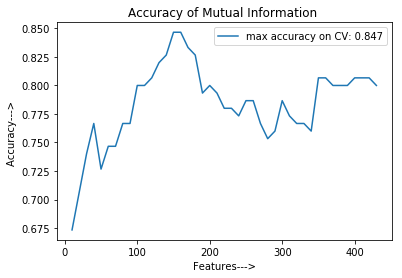

In [7]:
plt.plot(mi_ranks,avg_accuracy_list_logistic,label=f'max accuracy on CV: {max(avg_accuracy_list_logistic):.3f}')
plt.xlabel("Features--->")
plt.ylabel("Accuracy---> ")
plt.title("Accuracy of Mutual Information ")
plt.legend(loc=0)

### reducing the number of features to best_rank in both train and test:

In [8]:


X_test_mi=X_test_val.iloc[:,mi_selected_columns[best_rank]] #It will remove the equivalent columns from our test set as well
X_train_mi=X_train_val.iloc[:,mi_selected_columns[best_rank]] #removing from Train set as well 
#also, mi_selected_columns is a dictionary and it must have the key to find what columns were chosen for that key


### Mutual Information: checking accuracy on training data as well as validation set

In [9]:

logistic_clf=LogisticRegression()
logistic_clf.fit(X_train_mi.values,Y_train_val.values)

y_predict=logistic_clf.predict(X_train_mi.values)
        
tp=fp=tn=fn=i=0
        
while i < len(y_predict):
    if Y_train_val.values[i]==1 and y_predict[i]==1:             #corresponding actual y=1 and prediction =1 then it is True+ve
        tp+=1
    elif Y_train_val.values[i]==0 and y_predict[i]==1:           #corresponding actual y=0 and prediction =1 then it is False+ve
        fp+=1
    elif Y_train_val.values[i]==0 and y_predict[i]==0:           #corresponding actual y=0 and prediction =0 then it is True-ve
        tn+=1
    else:                                               #corresponding actual y=1 and prediction =0 then it is False-ve
        fn+=1
    i+=1

accuracy=(tp+tn)/(tp+tn+fp+fn) 

print(f"Accuracy on Training data set: {accuracy}\n")




y_predict=logistic_clf.predict(X_test_mi.values)
        
tp=fp=tn=fn=i=0
        
while i < len(y_predict):
    if Y_test_val.values[i]==1 and y_predict[i]==1:             #corresponding actual y=1 and prediction =1 then it is True+ve
        tp+=1
    elif Y_test_val.values[i]==0 and y_predict[i]==1:           #corresponding actual y=0 and prediction =1 then it is False+ve
        fp+=1
    elif Y_test_val.values[i]==0 and y_predict[i]==0:           #corresponding actual y=0 and prediction =0 then it is True-ve
        tn+=1
    else:                                               #corresponding actual y=1 and prediction =0 then it is False-ve
        fn+=1
    i+=1
        
accuracy=(tp+tn)/(tp+tn+fp+fn) 

print(f"Accuracy on Test data set: {accuracy}")


SP_test=tn/(tn+fp)
SN_test=tp/(tp+fn)

print(f"Specificity on validation data: {SP_test}\n")
print(f"Sensitivity on validation data: {SN_test}")















Accuracy on Training data set: 0.94

Accuracy on Test data set: 0.9
Specificity on validation data: 0.9

Sensitivity on validation data: 0.9


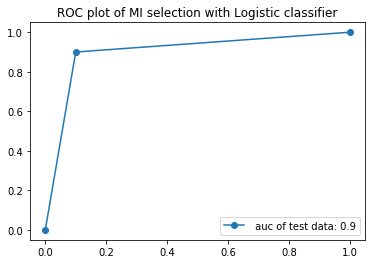

In [10]:


fpr,tpr,_=metrics.roc_curve(Y_test_val,y_predict)
auc_linear=metrics.roc_auc_score(Y_test_val,y_predict)

plt.plot(fpr,tpr,'o-',label=f' auc of test data: {auc_linear}')
plt.title("ROC plot of MI selection with Logistic classifier")
plt.legend(loc=0)


### testing with PCA to find if it is possible to visualize any clear separation

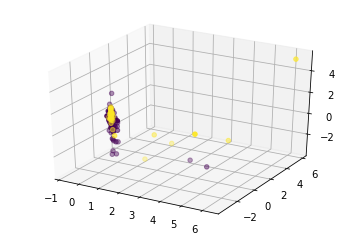

In [11]:
from sklearn.decomposition import PCA

PCA_clf=PCA(n_components=3,whiten=True)
data_df=PCA_clf.fit_transform(X_train_mi.values)

from mpl_toolkits.mplot3d import axes3d
df=pd.concat([data_labels_df,pd.DataFrame(data_df)],axis=1)
fig=plt.figure()
ax1=fig.add_subplot(111, projection='3d')
ax1.scatter(df[0].values,df[1].values,df[2].values,c=df['labels'])



## not possible!!

### RFE after Mutual Information

In [12]:
#RFE after Mutual Information:
#best_rank=150
X_train_mi=X_train_val.iloc[:,mi_selected_columns[best_rank]] #removing from Train set as well 
X_test_mi=X_test_val.iloc[:,mi_selected_columns[best_rank]] #It will remove the equivalent columns from our test set as well
logistic_mi_clf=LogisticRegression()

rfe_selected_columns=dict() #will keep track of selected column in each iteration

avg_accuracy_list_logistic=[]
feature_number_list=[x for x in range(1,best_rank+1,10)]
for wrapper_rank in feature_number_list:
    rfe_transform= RFE(logistic_clf,n_features_to_select=wrapper_rank) 
    params=[('RFE',rfe_transform),('logistic',logistic_mi_clf)]
    rfe_logistic=Pipeline(params)
    
    

    accuracy_list=[]  
    
    for train, test in logo_cv.split(X_train_mi.values, Y_train_val.values, group_cv):
       
        X_train_cv, X_test_cv = X_train_mi.values[train], X_train_mi.values[test]
        Y_train_cv, Y_test_cv = Y_train_val.values[train], Y_train_val.values[test]     
        
        
        rfe_logistic.fit(X_train_cv,Y_train_cv)
        y_predict=rfe_logistic.predict(X_test_cv)
        
        rfe_selected_columns[wrapper_rank]=rfe_logistic['RFE'].get_support(indices=True) #this will return a numpy array of all  selected -
                                            #indices from 150 Mutual Info features. Writing this line in the inner loop.
        
        
        tp=fp=tn=fn=i=0
        
        while i < len(y_predict):
            if Y_test_cv[i]==1 and y_predict[i]==1:             #corresponding actual y=1 and prediction =1 then it is True+ve
                tp+=1
            elif Y_test_cv[i]==0 and y_predict[i]==1:           #corresponding actual y=0 and prediction =1 then it is False+ve
                fp+=1
            elif Y_test_cv[i]==0 and y_predict[i]==0:           #corresponding actual y=0 and prediction =0 then it is True-ve
                tn+=1
            else:                                               #corresponding actual y=1 and prediction =0 then it is False-ve
                fn+=1
            i+=1
        
        accuracy=(tp+tn)/(tp+tn+fp+fn)                          #accuracy formula
        accuracy_list.append(accuracy)                          #storing history data in accuracy_list
        #print(accuracy_list)                                         
    avg_accuracy_list_logistic.append(statistics.mean(accuracy_list))    #finally adding the average accuracy of each model


best_rank_mi_rfe=feature_number_list[avg_accuracy_list_logistic.index(max(avg_accuracy_list_logistic))]


print(f"The average accuracy collected at every threshold:{avg_accuracy_list_logistic}")
print("\n")
print(f"The best threshold is {best_rank_mi_rfe} at highest accuracy ({max(avg_accuracy_list_logistic):.3f}) from LOGO cross-validation ")
print("\n")

The average accuracy collected at every threshold:[0.5266666666666666, 0.78, 0.76, 0.78, 0.8266666666666667, 0.84, 0.84, 0.84, 0.84, 0.8466666666666667, 0.8533333333333334, 0.8466666666666667, 0.8533333333333334, 0.8533333333333334, 0.8466666666666667]


The best threshold is 101 at highest accuracy (0.853) from LOGO cross-validation 




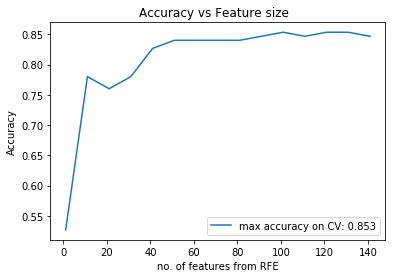

In [13]:
plt.plot(feature_number_list,avg_accuracy_list_logistic,label=f'max accuracy on CV: {max(avg_accuracy_list_logistic):.3f}')
plt.xlabel("no. of features from RFE")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Feature size  ")
plt.legend(loc=0)

### Now RFE has returned 101 best columns using cross validation:

### we need to know those 101 columns

### Training the model again with these 101 features and finding the prediction accuracy on Test set

In [14]:
X_train_mi_rfe=X_train_mi.iloc[:,rfe_selected_columns[best_rank_mi_rfe]] #now the columns are further reduced from X_train_mi
                                                                            #which was 150 initially.
#print(X_train_mi_rfe.shape[1]) # will give 101

X_test_mi_rfe=X_test_mi.iloc[:,rfe_selected_columns[best_rank_mi_rfe]] #reducing X_test features as well

logistic_clf=LogisticRegression()
logistic_clf.fit(X_train_mi_rfe.values,Y_train_val.values)

y_predict_mi_rfe_train=logistic_clf.predict(X_train_mi_rfe.values)
        
tp=fp=tn=fn=i=0
        
while i < len(y_predict_mi_rfe_train):
    if Y_train_val.values[i]==1 and y_predict_mi_rfe_train[i]==1:             #corresponding actual y=1 and prediction =1 then it is True+ve
        tp+=1
    elif Y_train_val.values[i]==0 and y_predict_mi_rfe_train[i]==1:           #corresponding actual y=0 and prediction =1 then it is False+ve
        fp+=1
    elif Y_train_val.values[i]==0 and y_predict_mi_rfe_train[i]==0:           #corresponding actual y=0 and prediction =0 then it is True-ve
        tn+=1
    else:                                               #corresponding actual y=1 and prediction =0 then it is False-ve
        fn+=1
    i+=1
    
accuracy_rfe_mi_train=(tp+tn)/(tp+tn+fp+fn) 

print(f"Accuracy on Training data set: {accuracy_rfe_mi_train}\n")



y_predict_mi_rfe_test=logistic_clf.predict(X_test_mi_rfe.values)
        
tp=fp=tn=fn=i=0
        
while i < len(y_predict_mi_rfe_test):
    if Y_test_val.values[i]==1 and y_predict_mi_rfe_test[i]==1:             #corresponding actual y=1 and prediction =1 then it is True+ve
        tp+=1
    elif Y_test_val.values[i]==0 and y_predict_mi_rfe_test[i]==1:           #corresponding actual y=0 and prediction =1 then it is False+ve
        fp+=1
    elif Y_test_val.values[i]==0 and y_predict_mi_rfe_test[i]==0:           #corresponding actual y=0 and prediction =0 then it is True-ve
        tn+=1
    else:                                               #corresponding actual y=1 and prediction =0 then it is False-ve
        fn+=1
    i+=1
        
accuracy_rfe_mi_test=(tp+tn)/(tp+tn+fp+fn) 
#print(f"{tp} {tn} {fp} {fn}")
print(f"Accuracy on Test data set: {accuracy_rfe_mi_test}")


SP_test=tn/(tn+fp)
SN_test=tp/(tp+fn)

print(f"Specificity on validation data: {SP_test}\n")
print(f"Sensitivity on validation data: {SN_test}")




Accuracy on Training data set: 0.9333333333333333

Accuracy on Test data set: 0.9
Specificity on validation data: 0.9

Sensitivity on validation data: 0.9


In [15]:
print(f"Predictions on test set : {y_predict_mi_rfe_test}\n")
print(f"Real Test set labels:     {Y_test_val.values}")

Predictions on test set : [0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1.
 0. 1. 1. 1. 1. 1.]

Real Test set labels:     [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1.]


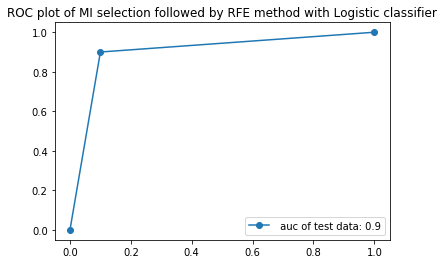

In [16]:


fpr,tpr,_=metrics.roc_curve(Y_test_val,y_predict_mi_rfe_test)
auc_linear=metrics.roc_auc_score(Y_test_val,y_predict_mi_rfe_test)

plt.plot(fpr,tpr,'o-',label=f' auc of test data: {auc_linear}')
plt.title("ROC plot of MI selection followed by RFE method with Logistic classifier")
plt.legend(loc=0)


### optimum features after RFE:

In [17]:
import pprint
pprint.pprint(f"The final optimum set of 101 features from MI-RFE which perhaps explains the data : {X_train_mi_rfe.columns.tolist()}")

('The final optimum set of 101 features from MI-RFE which perhaps explains the '
 "data : ['alpha_ec_3', 'alpha_ec_6', 'alpha_ec_9', 'alpha_ec_10', "
 "'alpha_ec_14', 'alpha_ec_15', 'alpha_ec_17', 'alpha_ec_18', 'alpha_ec_21', "
 "'alpha_ec_23', 'alpha_ec_25', 'alpha_ec_30', 'alpha_ec_31', 'alpha_ec_38', "
 "'alpha_ec_39', 'alpha_ec_42', 'alpha_ec_47', 'beta_ec_1', 'beta_ec_5', "
 "'beta_ec_11', 'beta_ec_13', 'beta_ec_19', 'beta_ec_20', 'beta_ec_30', "
 "'beta_ec_31', 'beta_ec_39', 'theta_ec_2', 'theta_ec_9', 'theta_ec_12', "
 "'theta_ec_20', 'theta_ec_21', 'theta_ec_25', 'theta_ec_26', 'theta_ec_27', "
 "'theta_ec_29', 'theta_ec_32', 'theta_ec_33', 'theta_ec_34', 'theta_ec_35', "
 "'alpha_eo_2', 'alpha_eo_3', 'alpha_eo_6', 'alpha_eo_9', 'alpha_eo_12', "
 "'alpha_eo_24', 'alpha_eo_32', 'alpha_eo_39', 'alpha_eo_43', 'alpha_eo_45', "
 "'alpha_eo_47', 'beta_eo_3', 'beta_eo_12', 'beta_eo_14', 'beta_eo_17', "
 "'beta_eo_18', 'beta_eo_22', 'beta_eo_26', 'beta_eo_35', 'theta_eo_2', "
 "'theta

### RFE removes some correlated columns but we can check if correlated columns are still remaining and whether removing correlated columns will lead to increase in accuracy or not 

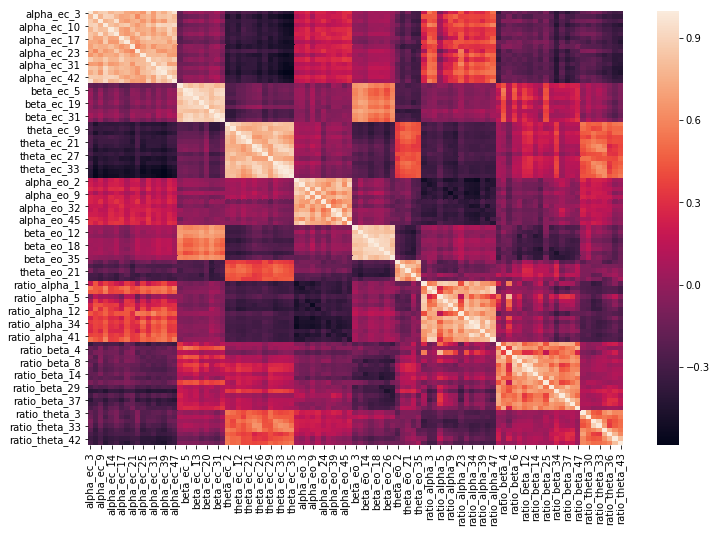

In [18]:

correlated_matrix=X_train_mi_rfe.corr(method='pearson')

plt.figure(figsize=(12,8))
sns.heatmap(correlated_matrix)

### plotting some remaining correlated columns:

Text(0,0.5,'theta_ec_12')

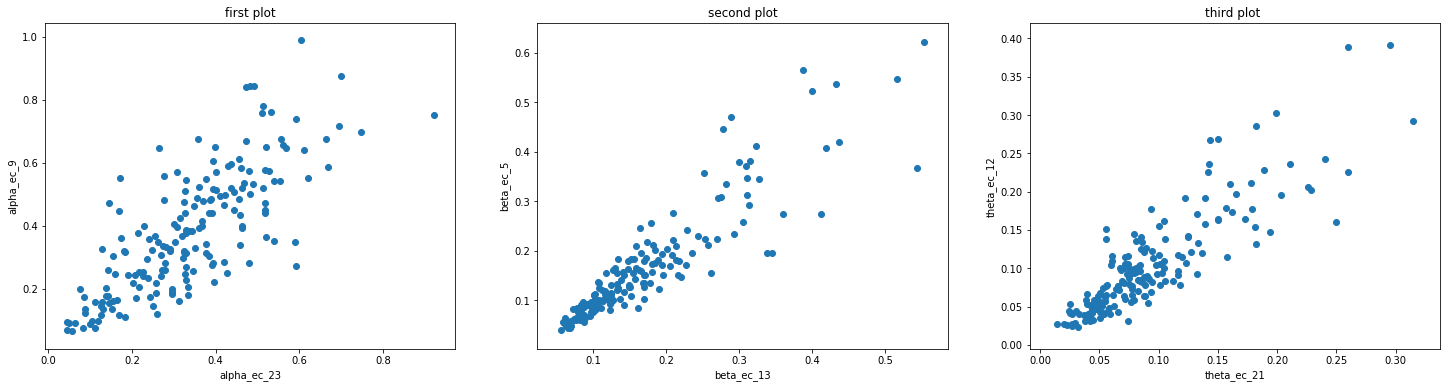

In [19]:
fig,axes=plt.subplots(nrows=1,ncols=3,figsize=(25,6))
axes[0].scatter(data_features_df['alpha_ec_23'],data_features_df['alpha_ec_9'])
axes[0].set_title("first plot")
axes[0].set_xlabel("alpha_ec_23")
axes[0].set_ylabel("alpha_ec_9")

axes[1].scatter(data_features_df['beta_ec_13'],data_features_df['beta_ec_5'])
axes[1].set_title("second plot")
axes[1].set_xlabel("beta_ec_13")
axes[1].set_ylabel("beta_ec_5")

axes[2].scatter(data_features_df['theta_ec_21'],data_features_df['theta_ec_12'])
axes[2].set_title("third plot ")
axes[2].set_xlabel("theta_ec_21")
axes[2].set_ylabel("theta_ec_12")

### custom function to remove the correlated columns

In [20]:
def finding_correlated_columns(features_df,threshold=0.9):
    correlated_columns=[]
    correlated_matrix=features_df.corr('pearson') #calling pandas corr() method which gives a correlation matrix
    
    #next the for loop will only check in one of the two halves of the matrix because it is symmetric on the diagonal
    
    for i in range(0,correlated_matrix.shape[1]):
        for j in range(0,i):
            if (correlated_matrix.iloc[i,j]>threshold)or(correlated_matrix.iloc[i,j]<-threshold): #checking which js are highly correlated with i
                correlated_columns.append(correlated_matrix.columns[i]) #if highly correlated, append to this list
    #print(correlated_columns)            
    return set(correlated_columns) #unique data

correlated_columns=finding_correlated_columns(X_train_mi_rfe,threshold=0.9)

print(f"Total correlated columns with threshold=0.9 is {len(correlated_columns)}")
print(f"Correlated columns: {correlated_columns}")
                   
print(f"remaining: {X_train_mi_rfe.shape[1]-len(correlated_columns)}")    

Total correlated columns with threshold=0.9 is 29
Correlated columns: {'ratio_alpha_35', 'ratio_alpha_47', 'beta_eo_18', 'alpha_ec_38', 'beta_ec_20', 'ratio_beta_13', 'beta_ec_19', 'theta_ec_33', 'alpha_ec_15', 'theta_ec_21', 'theta_ec_35', 'alpha_ec_42', 'alpha_eo_47', 'beta_eo_26', 'alpha_ec_39', 'alpha_ec_10', 'alpha_eo_43', 'beta_eo_22', 'ratio_alpha_41', 'alpha_ec_47', 'beta_ec_39', 'beta_eo_35', 'beta_ec_11', 'alpha_eo_12', 'ratio_alpha_12', 'beta_ec_13', 'theta_ec_34', 'theta_ec_26', 'beta_ec_31'}
remaining: 72


In [21]:
X_train_mi_rfe_corr=X_train_mi_rfe.copy() #making copies of mi_rfe selected features to work on pearsonr
X_test_mi_rfe_corr=X_test_mi_rfe.copy()


X_train_mi_rfe_corr.drop(correlated_columns, axis=1,inplace=True) #dropping the correlated columns from train data
X_test_mi_rfe_corr.drop(correlated_columns, axis=1,inplace=True) #dropping the correlated columns from test data

print(f"The total columns left after removing the correlated ones at threshold : {X_train_mi_rfe_corr.shape[1]}")
logistic_clf=LogisticRegression()
logistic_clf.fit(X_train_mi_rfe_corr.values,Y_train_val.values)

y_predict_corr_train=logistic_clf.predict(X_train_mi_rfe_corr.values)

tp=fp=tn=fn=i=0
        
while i < len(y_predict_corr_train):
    if Y_train_val.values[i]==1 and y_predict_corr_train[i]==1:             #corresponding actual y=1 and prediction =1 then it is True+ve
        tp+=1
    elif Y_train_val.values[i]==0 and y_predict_corr_train[i]==1:           #corresponding actual y=0 and prediction =1 then it is False+ve
        fp+=1
    elif Y_train_val.values[i]==0 and y_predict_corr_train[i]==0:           #corresponding actual y=0 and prediction =0 then it is True-ve
        tn+=1
    else:                                               #corresponding actual y=1 and prediction =0 then it is False-ve
        fn+=1
    i+=1
        
accuracy_mi_rfe_corr_train=(tp+tn)/(tp+tn+fp+fn) 

print(f"Accuracy on Training data set: {accuracy_mi_rfe_corr_train}\n")





y_predict_corr_test=logistic_clf.predict(X_test_mi_rfe_corr.values)
        
tp=fp=tn=fn=i=0
        
while i < len(y_predict_corr_test):
    if Y_test_val.values[i]==1 and y_predict_corr_test[i]==1:             #corresponding actual y=1 and prediction =1 then it is True+ve
        tp+=1
    elif Y_test_val.values[i]==0 and y_predict_corr_test[i]==1:           #corresponding actual y=0 and prediction =1 then it is False+ve
        fp+=1
    elif Y_test_val.values[i]==0 and y_predict_corr_test[i]==0:           #corresponding actual y=0 and prediction =0 then it is True-ve
        tn+=1
    else:                                               #corresponding actual y=1 and prediction =0 then it is False-ve
        fn+=1
    i+=1
        
accuracy_mi_rfe_test=(tp+tn)/(tp+tn+fp+fn) 

print(f"The accuracy on test set after removing correlated data: {accuracy_mi_rfe_test}\n")


SP_corr=tn/(tn+fp)                                         #Specificity
SN_corr=tp/(tp+fn)                                         #Sensitivity

print(f"Specificity on validation data: {SP_corr}\n")
print(f"Sensitivity on validation data: {SN_corr}")




The total columns left after removing the correlated ones at threshold : 72
Accuracy on Training data set: 0.9066666666666666

The accuracy on test set after removing correlated data: 0.9333333333333333

Specificity on validation data: 0.9

Sensitivity on validation data: 1.0


### We can see that Accuracy has increased on test data, after removing some correlated columns at threshold 0.9


In [22]:
pprint.pprint(f"Final columns remainging after MI, RFFE and Pearsonr feature selection: {X_train_mi_rfe_corr.columns.tolist()}")

('Final columns remainging after MI, RFFE and Pearsonr feature selection: '
 "['alpha_ec_3', 'alpha_ec_6', 'alpha_ec_9', 'alpha_ec_14', 'alpha_ec_17', "
 "'alpha_ec_18', 'alpha_ec_21', 'alpha_ec_23', 'alpha_ec_25', 'alpha_ec_30', "
 "'alpha_ec_31', 'beta_ec_1', 'beta_ec_5', 'beta_ec_30', 'theta_ec_2', "
 "'theta_ec_9', 'theta_ec_12', 'theta_ec_20', 'theta_ec_25', 'theta_ec_27', "
 "'theta_ec_29', 'theta_ec_32', 'alpha_eo_2', 'alpha_eo_3', 'alpha_eo_6', "
 "'alpha_eo_9', 'alpha_eo_24', 'alpha_eo_32', 'alpha_eo_39', 'alpha_eo_45', "
 "'beta_eo_3', 'beta_eo_12', 'beta_eo_14', 'beta_eo_17', 'theta_eo_2', "
 "'theta_eo_13', 'theta_eo_21', 'theta_eo_25', 'theta_eo_35', 'ratio_alpha_1', "
 "'ratio_alpha_3', 'ratio_alpha_4', 'ratio_alpha_5', 'ratio_alpha_6', "
 "'ratio_alpha_9', 'ratio_alpha_23', 'ratio_alpha_27', 'ratio_alpha_34', "
 "'ratio_alpha_39', 'ratio_beta_2', 'ratio_beta_4', 'ratio_beta_5', "
 "'ratio_beta_6', 'ratio_beta_8', 'ratio_beta_12', 'ratio_beta_14', "
 "'ratio_beta_21', 'ra

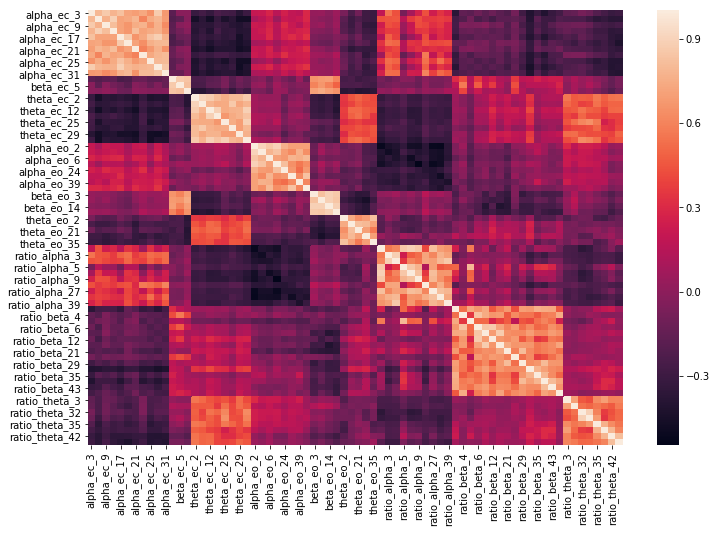

In [23]:

correlated_matrix=X_train_mi_rfe_corr.corr()

plt.figure(figsize=(12,8))
sns.heatmap(correlated_matrix)


## we are getting a more distinguishable diagonal which proves that some highly positively correlated columns have been removed and the remaining white diagonal is the correlation of a column with itself. We don't have to worry about it obviously

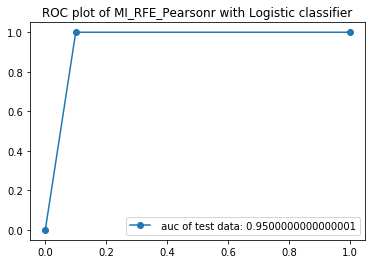

In [24]:


fpr,tpr,_=metrics.roc_curve(Y_test_val,y_predict_corr_test)
auc_linear=metrics.roc_auc_score(Y_test_val,y_predict_corr_test)

plt.plot(fpr,tpr,'o-',label=f' auc of test data: {auc_linear}')
plt.title("ROC plot of MI_RFE_Pearsonr with Logistic classifier")
plt.legend(loc=0)
